In [1]:
##############################################
# COVID-19 Analysis by Ezequiel Wajs
# github: @ewajs
##############################################

##############################################
# Imports & Config
##############################################
import datetime
from IPython.display import display, Markdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ssl
%matplotlib inline
# For Mac OSX Allows SSL
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
##############################################
# Data Retrieval
##############################################

url = 'https://raw.githubusercontent.com/datasets/covid-19/master/data/countries-aggregated.csv'
covid_base_df = pd.read_csv(url, error_bad_lines=False)
covid_base_df['Date'] = pd.to_datetime(covid_base_df['Date'])

In [3]:
# Fix Argentina data (from Wikipedia which tracks government announces)
arg_mask = covid_base_df['Country'] == 'Argentina'
quarantine_start_date = pd.to_datetime('3/20/20')
arg_corrected_dataset = (('3/3/20', 1),
('3/4/20', 1),
('3/5/20', 2),
('3/6/20', 8),
('3/7/20', 9),
('3/8/20', 12),
('3/9/20', 17),
('3/10/20', 19),
('3/11/20', 21),
('3/12/20', 31),
('3/13/20', 34),
('3/14/20', 45),
('3/15/20', 56),
('3/16/20', 65),
('3/17/20', 79),
('3/18/20', 97),
('3/19/20', 128),
('3/20/20', 158),
('3/21/20', 225),
('3/22/20', 266),
('3/23/20', 301),
('3/24/20', 387),
('3/25/20', 502),
('3/26/20', 589),
('3/27/20', 690),
('3/28/20', 745),
('3/29/20', 820),
('3/30/20', 966),
('3/31/20', 1054))
for date, confirmed in arg_corrected_dataset:
    covid_base_df.loc[arg_mask & (covid_base_df['Date'] == pd.to_datetime(date)), 'Confirmed'] = confirmed
   
        
covid_base_df.loc[arg_mask].sort_values('Date').tail(30)

,Date,Country,Confirmed,Recovered,Deaths
7206,2020-03-02,Argentina,0,0,0
7386,2020-03-03,Argentina,1,0,0
7566,2020-03-04,Argentina,1,0,0
7746,2020-03-05,Argentina,2,0,0
7926,2020-03-06,Argentina,8,0,0
8106,2020-03-07,Argentina,9,0,0
8286,2020-03-08,Argentina,12,0,1
8466,2020-03-09,Argentina,17,0,1
8646,2020-03-10,Argentina,19,0,1
8826,2020-03-11,Argentina,21,0,1


In [4]:
##############################################
# Data Formatting and calculation
##############################################
max_incubation_period = pd.to_timedelta('14 days') # From https://www.cdc.gov/coronavirus/2019-ncov/symptoms-testing/symptoms.html
mean_incubation_period = pd.to_timedelta('5 days') # from https://annals.org/aim/fullarticle/2762808/incubation-period-coronavirus-disease-2019-covid-19-from-publicly-reported
max_date = max(covid_base_df['Date'])


# For each country, calculate Infectious Rate
countries = covid_base_df['Country'].unique()
covid_base_df.sort_values('Date', inplace=True)
for country in countries:
    country_mask = covid_base_df['Country'] == country
    # Compute Infectious Rate and New Cases per day per country
    covid_base_df.loc[country_mask,'Infectious Rate'] = covid_base_df.loc[country_mask,'Confirmed'].pct_change()
    covid_base_df.loc[country_mask, 'New Cases'] = covid_base_df.loc[country_mask, 'Confirmed'] - \
                                covid_base_df.loc[country_mask, 'Confirmed']/(covid_base_df.loc[country_mask, 'Infectious Rate'] + 1)
    # Compute days since first case
    case_mask = covid_base_df['Confirmed'] > 0
    first_case_date = min(covid_base_df.loc[country_mask & case_mask, 'Date'])
    # Set to 0 the Days since outbreak for days prior to first date
    covid_base_df.loc[country_mask & ~case_mask, 'Days since outbreak'] = 0
    # Set to 1 the Days since outbreak for days after and including first date
    covid_base_df.loc[country_mask & case_mask, 'Days since outbreak'] = 1
    # Replace Days since outbreak with its cumulative sum minus 1 (so first case is day 0)
    covid_base_df.loc[country_mask, 'Days since outbreak'] = covid_base_df.loc[country_mask, 'Days since outbreak'].cumsum().astype(int) - 1

display(Markdown('# Loaded COVID-19 Dataset'))
display(Markdown('## Found ' + str(len(covid_base_df.index)) + ' logs up until ' + str(max_date)))
display(covid_base_df.tail(50))

# Loaded COVID-19 Dataset

## Found 12600 logs up until 2020-03-31 00:00:00

,Date,Country,Confirmed,Recovered,Deaths,Infectious Rate,New Cases,Days since outbreak
12436,2020-03-31,Belgium,12775,1696,705,0.073620,876.0,56.0
12437,2020-03-31,Belize,3,0,0,0.000000,0.0,8.0
12460,2020-03-31,Costa Rica,347,4,2,0.051515,17.0,25.0
12461,2020-03-31,Cote d'Ivoire,179,7,1,0.065476,11.0,20.0
12462,2020-03-31,Croatia,867,67,6,0.097468,77.0,35.0
12463,2020-03-31,Cuba,186,8,6,0.094118,16.0,19.0
12488,2020-03-31,Grenada,9,0,0,0.000000,0.0,9.0
12489,2020-03-31,Guatemala,38,12,1,0.055556,2.0,17.0
12490,2020-03-31,Guinea,22,0,0,0.000000,0.0,18.0
12491,2020-03-31,Guinea-Bissau,8,0,0,0.000000,0.0,6.0


In [5]:
##############################################
# Inspecting the <Country> Situation
##############################################
country = 'Argentina'
country_mask = covid_base_df['Country'] == country
covid_country_df = covid_base_df.loc[country_mask].copy()
max_date = max(covid_country_df['Date'])
latest_data_row = covid_country_df.loc[covid_country_df['Date'] == max_date].iloc[0]
display(Markdown(f'# Looking at the situation in {country}'))
display(Markdown(f'### Latest Date: {str(max_date)}'))
display(Markdown(f'### Confirmed Cases: {latest_data_row["Confirmed"]}'))
display(Markdown(f'### Deaths: {latest_data_row["Deaths"]}'))
display(Markdown(f'### Recovered: {latest_data_row["Recovered"]}'))
display(Markdown(f'### Infectious Rate: {latest_data_row["Infectious Rate"]*100:.4}%'))
display(Markdown(f'## Base Data'))
display(covid_base_df.loc[country_mask].sort_values('Date').tail(30))

# Looking at the situation in Argentina

### Latest Date: 2020-03-31 00:00:00

### Confirmed Cases: 1054

### Deaths: 27

### Recovered: 240

### Infectious Rate: 9.11%

## Base Data

,Date,Country,Confirmed,Recovered,Deaths,Infectious Rate,New Cases,Days since outbreak
7206,2020-03-02,Argentina,0,0,0,NaN,NaN,-1.0
7386,2020-03-03,Argentina,1,0,0,inf,1.0,0.0
7566,2020-03-04,Argentina,1,0,0,0.000000,0.0,1.0
7746,2020-03-05,Argentina,2,0,0,1.000000,1.0,2.0
7926,2020-03-06,Argentina,8,0,0,3.000000,6.0,3.0
8106,2020-03-07,Argentina,9,0,0,0.125000,1.0,4.0
8286,2020-03-08,Argentina,12,0,1,0.333333,3.0,5.0
8466,2020-03-09,Argentina,17,0,1,0.416667,5.0,6.0
8646,2020-03-10,Argentina,19,0,1,0.117647,2.0,7.0
8826,2020-03-11,Argentina,21,0,1,0.105263,2.0,8.0


In [6]:
def transform_to_categories(df, cols):
    """"Will transform a dataset to one in which the provided columns form
    a categorical variable. Final rows in the output dataset will be
    original values times amount of columns provided"""
    cols_to_keep = list(set(df.columns) - set(cols))
    output_df = pd.DataFrame()
    for col in cols:
        # Extract columns to be kept and nth categorical column
        tmp_cols = cols_to_keep + [col,]
        tmp_df = df[tmp_cols].copy()
        # Rename last column as amount
        tmp_df.columns = tmp_cols[:-1] + ['Amount',]
        # Broadcast value for this column in the new categorical variable
        tmp_df['Type'] = col
        # Concatenate in output (accumulator)
        output_df = pd.concat([output_df, tmp_df])

    return output_df

# Create new DataFrame with categorical column
columns_to_cat = ['Confirmed', 'Recovered', 'Deaths', 'Infectious Rate', 'New Cases']
covid_cat_df = transform_to_categories(covid_base_df, columns_to_cat) 

## First case detected in 2020-03-03 00:00:00

### New and Confirmed cases by Date

Argentina has deployed **Quarantine or Isolation measures** on 2020-03-20 00:00:00.

The **Mean Incubation Period** of 5 days 00:00:00 
    has finished since the start of the quarantine and has occured on 2020-03-25 00:00:00.

The **Maximum Incubation Period** of 14 days 00:00:00 
    has not elapsed since the start of the quarantine and it will occur on 2020-04-03 00:00:00.

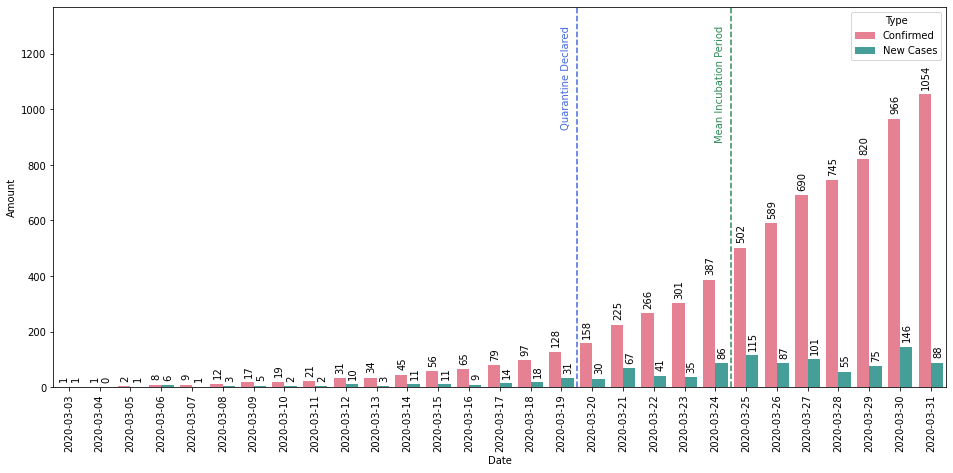

In [7]:
# Filter by country
covid_country_cat_df = covid_cat_df[covid_cat_df['Country'] == country].sort_values('Date').copy()

# Date of first case
first_case_date = min(covid_country_cat_df.loc[(covid_country_cat_df['Amount'] > 0) & 
                                               (covid_country_cat_df['Type'] == 'Confirmed'), 'Date'])
# Trim dataframe of previous dates
covid_country_cat_df = covid_country_cat_df.loc[covid_country_cat_df['Date'] >= first_case_date]
display(Markdown(f'## First case detected in {first_case_date}'))
display(Markdown('### New and Confirmed cases by Date'))

# Plot Confirmed and new cases data
types_to_graph = ['Confirmed', 'New Cases']
plt.figure(figsize=(16, 7))
plot_df = covid_country_cat_df[covid_country_cat_df['Type'].isin(types_to_graph)].copy()
chart = sns.barplot(x='Date', y='Amount', hue='Type', palette="husl", data=plot_df)
for p in chart.patches:
    chart.annotate(format(p.get_height(), '.0f'),
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', 
                   va = 'bottom', 
                   xytext = (1, 5), 
                   textcoords = 'offset points',
                   rotation = 90)

# Set upper margins above max value    
upper_margin = max(plot_df['Amount'])*1.3
plt.ylim(0, upper_margin)

# Add Date as labels in x axis
date_labels = list(plot_df['Date'].dt.date.unique())
chart.set_xticklabels(date_labels, rotation=90)

# Plot quarantine measures line
try:
    quarantine_label_index = date_labels.index(quarantine_start_date)
    plt.axvline(x=quarantine_label_index - 0.5, ls='--', color='royalblue')
    plt.text(quarantine_label_index - 1,upper_margin*0.95,'Quarantine Declared',rotation=90, color='royalblue', va='top')
    display(Markdown(f'''{country} has deployed **Quarantine or Isolation measures** on {quarantine_start_date}.'''))
except ValueError: 
    display(Markdown(f'''No **Quarantine or Isolation measures** have been deployed in {country}.'''))

# Plot Mean incubation period line since quarantine if possible
try:    
    mean_incubation_label_index = date_labels.index(quarantine_start_date + mean_incubation_period)
    plt.axvline(x=mean_incubation_label_index - 0.5, ls='--', color='seagreen')
    plt.text(mean_incubation_label_index - 1,upper_margin*0.95,'Mean Incubation Period',rotation=90, color='seagreen', va='top')
    display(Markdown(f'''The **Mean Incubation Period** of {mean_incubation_period} 
    has finished since the start of the quarantine and has occured on {quarantine_start_date + mean_incubation_period}.'''))
except ValueError:
    display(Markdown(f'''The **Mean Incubation Period** of {mean_incubation_period} 
    has not elapsed since the start of the quarantine and it will occur on {quarantine_start_date + mean_incubation_period}.'''))

# Plot Maximum incubation period line since quarantine if possible
try:    
    max_incubation_label_index = date_labels.index(quarantine_start_date + max_incubation_period)
    plt.axvline(x=max_incubation_label_index - 0.5, ls='--', color='indigo')
    plt.text(max_incubation_label_index - 1,upper_margin*0.95,'Maximum Incubation Period since Quarantine',rotation=90, color='indigo', va='top')
    display(Markdown(f'''The **Maximum Incubation Period** of {max_incubation_period} 
    has finished since the start of the quarantine and it has occured on {quarantine_start_date + max_incubation_period}.'''))
except ValueError:
    display(Markdown(f'''The **Maximum Incubation Period** of {max_incubation_period} 
    has not elapsed since the start of the quarantine and it will occur on {quarantine_start_date + max_incubation_period}.'''))


### Deaths and Recovered cases by Date

Argentina has deployed **Quarantine or Isolation measures** on 2020-03-20 00:00:00.

The **Mean Incubation Period** of 5 days 00:00:00 
    has finished since the start of the quarantine and has occured on 2020-03-25 00:00:00.

The **Maximum Incubation Period** of 14 days 00:00:00 
    has not elapsed since the start of the quarantine and it will occur on 2020-04-03 00:00:00.

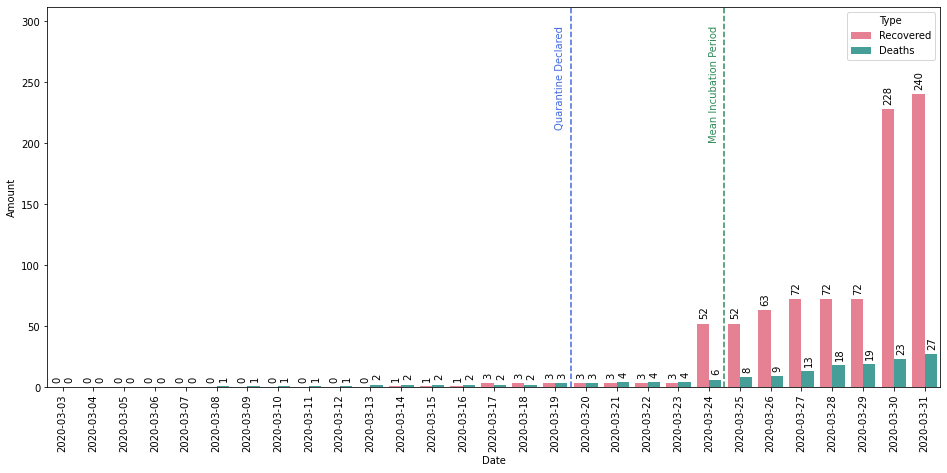

In [8]:
# Plot Deaths and Recoveries data
types_to_graph = ['Deaths', 'Recovered']
plt.figure(figsize=(16, 7))
plot_df = covid_country_cat_df[covid_country_cat_df['Type'].isin(types_to_graph)].copy()
chart = sns.barplot(x='Date', y='Amount', hue='Type', palette="husl", data=plot_df)
for p in chart.patches:
    chart.annotate(format(p.get_height(), '.0f'),
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', 
                   va = 'bottom', 
                   xytext = (1, 5), 
                   textcoords = 'offset points',
                   rotation = 90)
display(Markdown('### Deaths and Recovered cases by Date'))

# Set upper margins above max value    
upper_margin = max(plot_df['Amount'])*1.3
plt.ylim(0, upper_margin)

# Add Date as labels in x axis
date_labels = list(plot_df['Date'].dt.date.unique())
chart.set_xticklabels(date_labels, rotation=90)

# Plot quarantine measures line
try:
    quarantine_label_index = date_labels.index(quarantine_start_date)
    plt.axvline(x=quarantine_label_index - 0.5, ls='--', color='royalblue')
    plt.text(quarantine_label_index - 1,upper_margin*0.95,'Quarantine Declared',rotation=90, color='royalblue', va='top')
    display(Markdown(f'''{country} has deployed **Quarantine or Isolation measures** on {quarantine_start_date}.'''))
except ValueError: 
    display(Markdown(f'''No **Quarantine or Isolation measures** have been deployed in {country}.'''))

# Plot Mean incubation period line since quarantine if possible
try:    
    mean_incubation_label_index = date_labels.index(quarantine_start_date + mean_incubation_period)
    plt.axvline(x=mean_incubation_label_index - 0.5, ls='--', color='seagreen')
    plt.text(mean_incubation_label_index - 1,upper_margin*0.95,'Mean Incubation Period',rotation=90, color='seagreen', va='top')
    display(Markdown(f'''The **Mean Incubation Period** of {mean_incubation_period} 
    has finished since the start of the quarantine and has occured on {quarantine_start_date + mean_incubation_period}.'''))
except ValueError:
    display(Markdown(f'''The **Mean Incubation Period** of {mean_incubation_period} 
    has not elapsed since the start of the quarantine and it will occur on {quarantine_start_date + mean_incubation_period}.'''))

# Plot Maximum incubation period line since quarantine if possible
try:    
    max_incubation_label_index = date_labels.index(quarantine_start_date + max_incubation_period)
    plt.axvline(x=max_incubation_label_index - 0.5, ls='--', color='indigo')
    plt.text(max_incubation_label_index - 1,upper_margin*0.95,'Maximum Incubation Period since Quarantine',rotation=90, color='indigo', va='top')
    display(Markdown(f'''The **Maximum Incubation Period** of {max_incubation_period} 
    has finished since the start of the quarantine and it has occured on {quarantine_start_date + max_incubation_period}.'''))
except ValueError:
    display(Markdown(f'''The **Maximum Incubation Period** of {max_incubation_period} 
    has not elapsed since the start of the quarantine and it will occur on {quarantine_start_date + max_incubation_period}.'''))


### Infectious Rate (percent change between days)

Argentina has deployed **Quarantine or Isolation measures** on 2020-03-20 00:00:00.

The **Mean Incubation Period** of 5 days 00:00:00 
    has finished since the start of the quarantine and has occured on 2020-03-25 00:00:00.

The **Maximum Incubation Period** of 14 days 00:00:00 
    has not elapsed since the start of the quarantine and it will occur on 2020-04-03 00:00:00.

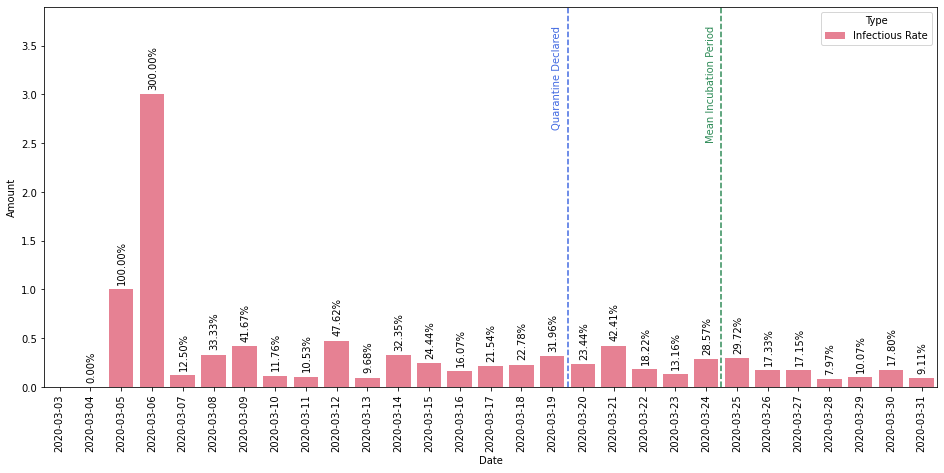

In [9]:
# Plot Deaths and Recoveries data
types_to_graph = ['Infectious Rate']
plt.figure(figsize=(16, 7))
plot_df = covid_country_cat_df[covid_country_cat_df['Type'].isin(types_to_graph)].copy()
chart = sns.barplot(x='Date', y='Amount', hue='Type', palette="husl", data=plot_df)
for p in chart.patches:
    chart.annotate(format(p.get_height()*100, '.2f') + '%',
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', 
                   va = 'bottom', 
                   xytext = (1, 5), 
                   textcoords = 'offset points',
                   rotation = 90)

display(Markdown('### Infectious Rate (percent change between days)'))

# Set upper margins above max value    
upper_margin = max([v for v in plot_df['Amount'].dropna() if v != np.inf])*1.3
plt.ylim(0, upper_margin)

# Add Date as labels in x axis
date_labels = list(plot_df['Date'].dt.date.unique())
chart.set_xticklabels(date_labels, rotation=90)

# Plot quarantine measures line
try:
    quarantine_label_index = date_labels.index(quarantine_start_date)
    plt.axvline(x=quarantine_label_index - 0.5, ls='--', color='royalblue')
    plt.text(quarantine_label_index - 1,upper_margin*0.95,'Quarantine Declared',rotation=90, color='royalblue', va='top')
    display(Markdown(f'''{country} has deployed **Quarantine or Isolation measures** on {quarantine_start_date}.'''))
except ValueError: 
    display(Markdown(f'''No **Quarantine or Isolation measures** have been deployed in {country}.'''))

# Plot Mean incubation period line since quarantine if possible
try:    
    mean_incubation_label_index = date_labels.index(quarantine_start_date + mean_incubation_period)
    plt.axvline(x=mean_incubation_label_index - 0.5, ls='--', color='seagreen')
    plt.text(mean_incubation_label_index - 1,upper_margin*0.95,'Mean Incubation Period',rotation=90, color='seagreen', va='top')
    display(Markdown(f'''The **Mean Incubation Period** of {mean_incubation_period} 
    has finished since the start of the quarantine and has occured on {quarantine_start_date + mean_incubation_period}.'''))
except ValueError:
    display(Markdown(f'''The **Mean Incubation Period** of {mean_incubation_period} 
    has not elapsed since the start of the quarantine and it will occur on {quarantine_start_date + mean_incubation_period}.'''))

# Plot Maximum incubation period line since quarantine if possible
try:    
    max_incubation_label_index = date_labels.index(quarantine_start_date + max_incubation_period)
    plt.axvline(x=max_incubation_label_index - 0.5, ls='--', color='indigo')
    plt.text(max_incubation_label_index - 1,upper_margin*0.95,'Maximum Incubation Period since Quarantine',rotation=90, color='indigo', va='top')
    display(Markdown(f'''The **Maximum Incubation Period** of {max_incubation_period} 
    has finished since the start of the quarantine and it has occured on {quarantine_start_date + max_incubation_period}.'''))
except ValueError:
    display(Markdown(f'''The **Maximum Incubation Period** of {max_incubation_period} 
    has not elapsed since the start of the quarantine and it will occur on {quarantine_start_date + max_incubation_period}.'''))


In [10]:

countries_to_compare = [country, ] + ['China', 'US', 'Italy', 'Korea, South']

# Extract data from base dataset
covid_countries_base_df = covid_base_df.loc[covid_base_df['Country'].isin(countries_to_compare)].copy()

def transform_to_days_since_outbreak(df):
    """Will generate a new dataframe with categories and countries to graph"""
    output_df = pd.DataFrame()
    cols_to_pivot = list(set(df.columns) - set(['Country', 'Days since outbreak', 'Date']))
    countries = df['Country'].unique()
    for col in cols_to_pivot:
        for country in countries:
            country_mask = df['Country'] == country
            date_mask = df['Days since outbreak'] >= 0
            # Keep all rows since outbreak started for given country plus the column to pivot
            tmp_df = df.loc[country_mask & date_mask, ['Country', 'Days since outbreak'] + [col,]].copy()
            # Change name of column to amount
            tmp_df.rename(columns={col: 'Amount'}, inplace=True)
            # Broadcast type to column title
            tmp_df['Type'] = col
            output_df = pd.concat([output_df, tmp_df])
    return output_df

covid_countries_cat_df = transform_to_days_since_outbreak(covid_countries_base_df)

# Comparing Argentina to other countries

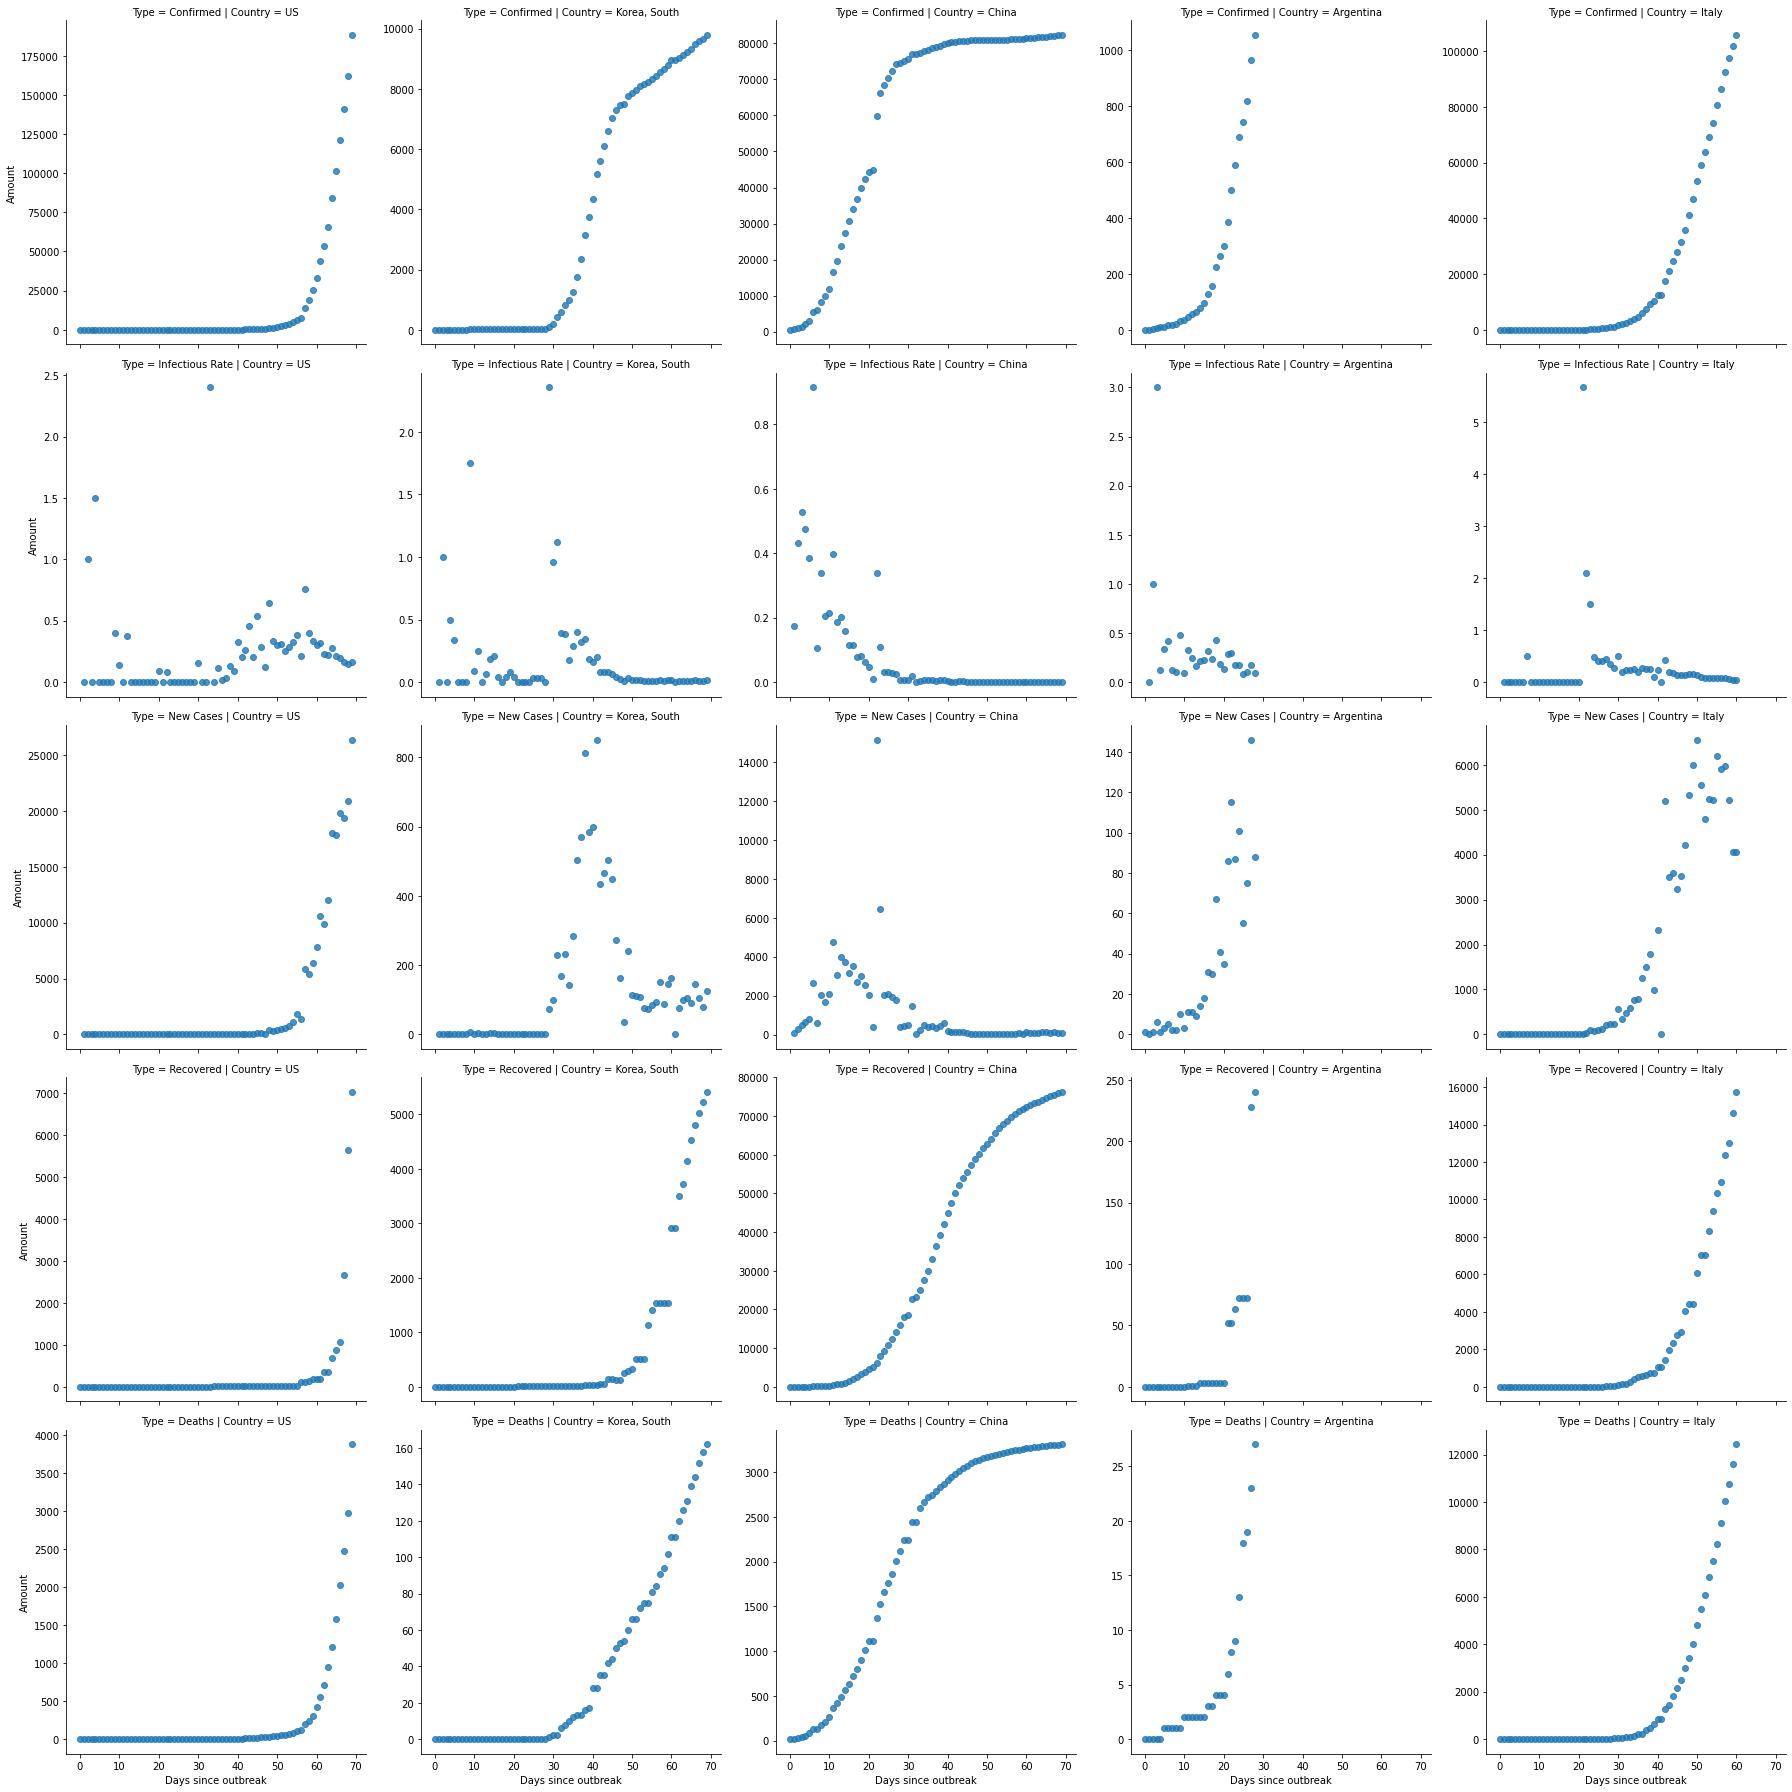

In [11]:
display(Markdown(f'# Comparing {country} to other countries'))
covid_countries_cat_df.sort_values('Days since outbreak').tail()
sns.lmplot(data=covid_countries_cat_df, 
           x='Days since outbreak', 
           y='Amount', 
           row='Type', 
           row_order = ['Confirmed', 'Infectious Rate', 'New Cases', 'Recovered', 'Deaths'],
           col='Country', 
           palette='husl',
           sharey=False,
           fit_reg=False)

## Plotting cases logarithmically by Country by Days since outbreak

### A line going upwards represents cases growing exponentially (uncontrolled)

### The slope of this line represents the speed at which the virus spreads

### Horizontal lines mean that confirmed cases have stabilized

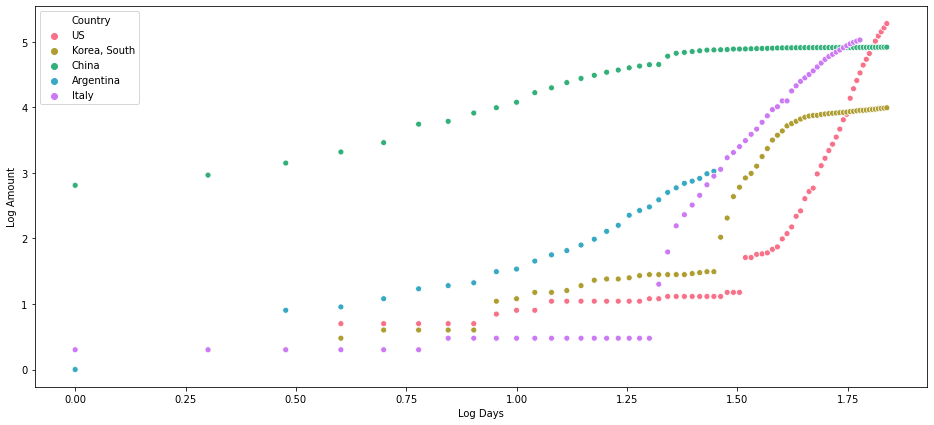

In [12]:
display(Markdown('## Plotting cases logarithmically by Country by Days since outbreak'))
display(Markdown('### A line going upwards represents cases growing exponentially (uncontrolled)'))
display(Markdown('### The slope of this line represents the speed at which the virus spreads'))
display(Markdown('### Horizontal lines mean that confirmed cases have stabilized'))
# Compute log
np.seterr(divide = 'ignore') 
covid_countries_cat_df['Log Amount'] = np.log10(covid_countries_cat_df['Amount'])
covid_countries_cat_df['Log Days'] = np.log10(covid_countries_cat_df['Days since outbreak'])
confirmed_mask = covid_countries_cat_df['Type'] == 'Confirmed'
covid_confirm_countries_cat_df = covid_countries_cat_df.loc[confirmed_mask].copy()
plt.figure(figsize=(16, 7))
sns.scatterplot(data=covid_confirm_countries_cat_df, 
           x='Log Days', 
           y='Log Amount', 
           hue='Country', 
           palette='husl')

## Plotting Log Confirmed by New Cases by Log Confirmed

### A line going upwards represents cases growing exponentially (uncontrolled)

### The upward slope going suddenly down means confirmed cases have stabilized

### Vertical postion (y coordinate) is a logarithmic scale of the New Cases (cases = 10^y)

### Horitzontal postion (x coordinate) is a logarithmic scale of the Confirmed cases (cases = 10^x)

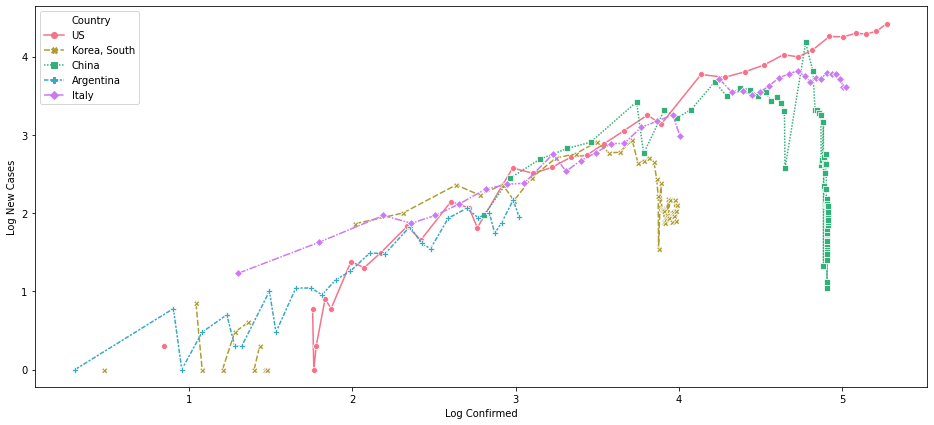

In [13]:
display(Markdown('## Plotting Log Confirmed by New Cases by Log Confirmed'))
display(Markdown('### A line going upwards represents cases growing exponentially (uncontrolled)'))
display(Markdown('### The upward slope going suddenly down means confirmed cases have stabilized'))
display(Markdown('### Vertical postion (y coordinate) is a logarithmic scale of the New Cases (cases = 10^y)'))
display(Markdown('### Horitzontal postion (x coordinate) is a logarithmic scale of the Confirmed cases (cases = 10^x)'))
# Compute log
np.seterr(divide = 'ignore') 
covid_countries_cat_df['Log Amount'] = np.log10(covid_countries_cat_df['Amount'])
covid_countries_cat_df['Log Days'] = np.log10(covid_countries_cat_df['Days since outbreak'])
confirmed_mask = covid_countries_cat_df['Type'] == 'Confirmed'
covid_confirm_countries_cat_df = covid_countries_cat_df.loc[confirmed_mask].copy()
covid_confirm_countries_cat_df.rename(columns={'Log Amount': 'Log Confirmed'}, inplace=True)
new_cases_mask = covid_countries_cat_df['Type'] == 'New Cases'
covid_new_cases_countries_cat_df = covid_countries_cat_df.loc[new_cases_mask].copy()
covid_new_cases_countries_cat_df.rename(columns={'Log Amount': 'Log New Cases'}, inplace=True)

covid_new_vs_confirm_countries_df = pd.merge(covid_confirm_countries_cat_df[['Days since outbreak', 
                                                                             'Log Confirmed', 
                                                                             'Country']],
                                             covid_new_cases_countries_cat_df[['Days since outbreak', 
                                                                             'Log New Cases', 
                                                                             'Country']],
                                             on = ['Days since outbreak', 'Country'],
                                             how = 'inner')
plt.figure(figsize=(16, 7))
sns.lineplot(data=covid_new_vs_confirm_countries_df, 
           x='Log Confirmed', 
           y='Log New Cases', 
           hue='Country', 
           style='Country', 
           palette='husl',
           markers=True)